In [1]:
import polars as pl
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('C:\\Users\\moham\\My Drive\\Course\\Structural Econometrics Projects\\Topics in Advanced Econometrics\\LPM\\commute_binary.csv')

In [6]:
df.head(4)

,id,mode,time.car,cost.car,time.bus,cost.bus,price_gas,snowfall,construction,bus_detour,age,income,marital_status
0,1,car,13,0.79,26,0,2.44,0.0,0,1,33,28,married
1,2,car,9,0.59,14,0,2.59,0.0,0,0,25,28,single
2,3,bus,20,1.62,35,0,2.55,1.0,0,0,27,23,single
3,4,bus,11,0.30,11,0,2.53,2.2,0,0,25,21,single


# Problem 1: Summary Statistics

### Full summary stat

In [7]:
summary = df[['time.car', 'cost.car', 'time.bus', 'cost.bus']].describe()
print(summary.round(2))

       time.car  cost.car  time.bus  cost.bus
count   1000.00   1000.00   1000.00    1000.0
mean      10.95      0.41     14.16       0.0
std        3.00      0.21      4.47       0.0
min        5.00      0.16      7.00       0.0
25%        9.00      0.26     11.00       0.0
50%       10.00      0.35     13.00       0.0
75%       13.00      0.50     16.00       0.0
max       28.00      1.62     39.00       0.0


### Long right tail of the variables

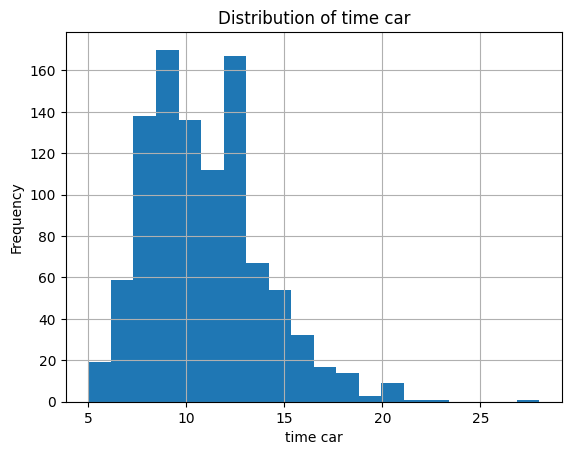

In [6]:
import matplotlib.pyplot as plt

df['time.car'].hist(bins=20)

# add labels and title
plt.xlabel('time car')
plt.ylabel('Frequency')
plt.title('Distribution of time car')
plt.show()

### Summary stat by mode of commute

In [7]:
new_df = df.groupby('mode').agg(
    time_car_mean=('time.car', 'mean'),
    time_car_median=('time.car', 'median'),
    cost_car_mean=('cost.car', 'mean'),
     cost_car_median=('cost.car', 'median'),
    time_bus_mean=('time.bus', 'mean'),
    time_bus_median=('time.bus', 'median')
)
new_df.round(2)

,time_car_mean,time_car_median,cost_car_mean,cost_car_median,time_bus_mean,time_bus_median
mode,,,,,,
bus,11.88,11.0,0.45,0.38,14.69,13.0
car,9.70,9.0,0.36,0.32,13.47,13.0


# Problem 2: Linear Probability Model

The model is as follows:
$$
Y_n=\beta_0+\beta_1 C_{n c}+\beta_2 T_{n c}+\beta_3 T_{n b}+\varepsilon_n
$$

In [8]:
df['output'] = df['mode'].map({'car': 1, 'bus': 0})

In [18]:
import statsmodels.api as sm

# Define the independent variables
X = df[['cost.car', 'time.car', 'time.bus']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['output']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     64.46
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           4.27e-38
Time:                        18:05:31   Log-Likelihood:                -636.12
No. Observations:                1000   AIC:                             1280.
Df Residuals:                     996   BIC:                             1300.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9205      0.073     12.627      0.0

In [19]:
df['predict_LPM'] = model.predict(X)
count = df[(df['predict_LPM'] > 1) | (df['predict_LPM'] < 0)].shape[0]
print(count)

22


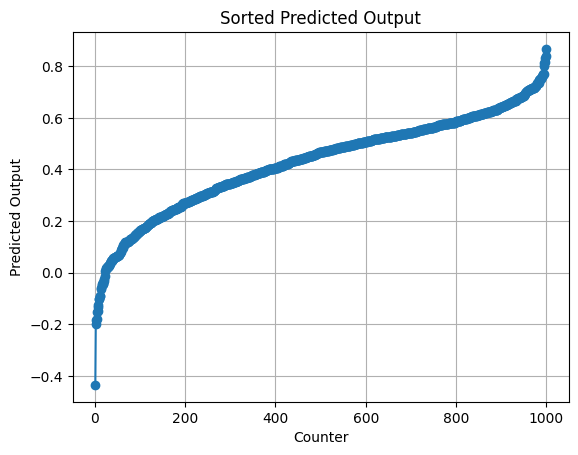

In [21]:
df_sorted = df.sort_values(by='predict_LPM').reset_index(drop=True)

# Generate a counter for the x-axis
df_sorted['counter'] = df_sorted.index + 1

# Plot the sorted data
plt.plot(df_sorted['counter'], df_sorted['predict_LPM'], marker='o')
plt.xlabel('Counter')
plt.ylabel('Predicted Output')
plt.title('Sorted Predicted Output')
plt.grid(True)
plt.show()

So, for 22 students, the prediction of the model for the probability of riding a car is not relevant. It is indeed not a large number.

In [17]:
import numpy as np
from scipy.stats import t

# Get the coefficients from the model
coefficients = model.params

# Extract the coefficients for time.car and time.bus
time_car_coefficient = coefficients['time.car']
time_bus_coefficient = coefficients['time.bus']

# Calculate the absolute difference between the coefficients
absolute_difference = np.abs(time_car_coefficient) - np.abs(time_bus_coefficient)

# Calculate the standard error of the difference
standard_error = np.sqrt(model.cov_params().loc['time.car', 'time.car']
                         + model.cov_params().loc['time.bus', 'time.bus'])

# Calculate the t-statistic
t_statistic = absolute_difference / standard_error

# Calculate the degrees of freedom
degrees_of_freedom = len(df) - len(coefficients)

# Calculate the p-value
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), degrees_of_freedom))

# Print the results
print(f'T-statistic: {t_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

T-statistic: 4.1396
P-value: 0.0000


So the coefficients of timecar and timebus in absoulute terms are different significantly.

## A more detailed model

The model is as follows:
$$
Y_n=\beta_0+\beta_1 C_{n c}+\beta_2 T_{n c}+\beta_3 T_{n b}+
\beta_4 Age_{n} + \beta_{5} Income_{n} + \beta_{6}
Marital_{n} + \varepsilon_n
$$

In [12]:
df['Marital'] = df['marital_status'].map({'married': 1, 'single': 0})

In [22]:
# Define the independent variables
X = df[['cost.car', 'time.car', 'time.bus', 'income',
       'Marital']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['output']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     46.29
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           4.58e-43
Time:                        18:06:01   Log-Likelihood:                -628.00
No. Observations:                1000   AIC:                             1268.
Df Residuals:                     994   BIC:                             1297.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7081      0.115      6.171      0.0

In [23]:
correlation_matrix = X[['cost.car', 'time.car', 'time.bus', 'income', 'Marital']].corr()
print(correlation_matrix)

          cost.car  time.car  time.bus    income   Marital
cost.car  1.000000  0.616969  0.869822 -0.011682 -0.031008
time.car  0.616969  1.000000  0.581246  0.039668 -0.012954
time.bus  0.869822  0.581246  1.000000 -0.001899 -0.008198
income   -0.011682  0.039668 -0.001899  1.000000  0.012660
Marital  -0.031008 -0.012954 -0.008198  0.012660  1.000000


In [24]:
df['predict_LPM'] = model.predict(X)
count = df[(df['predict_LPM'] > 1) | (df['predict_LPM'] < 0)].shape[0]
print(count)

27


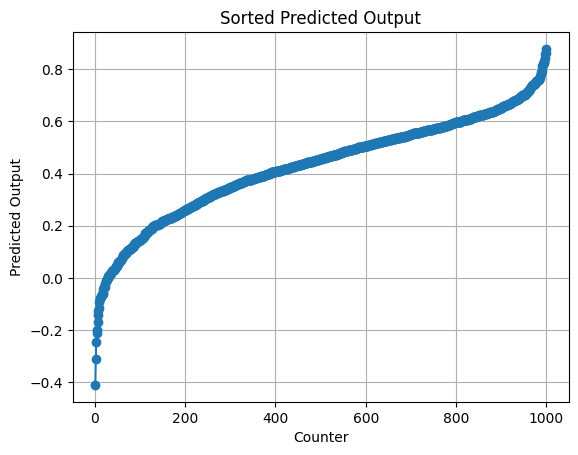

In [25]:
df_sorted = df.sort_values(by='predict_LPM').reset_index(drop=True)

# Generate a counter for the x-axis
df_sorted['counter'] = df_sorted.index + 1

# Plot the sorted data
plt.plot(df_sorted['counter'], df_sorted['predict_LPM'], marker='o')
plt.xlabel('Counter')
plt.ylabel('Predicted Output')
plt.title('Sorted Predicted Output')
plt.grid(True)
plt.show()